In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

In [2]:
eventDate = datetime.datetime(2011,5,16)
timeStart = datetime.datetime(2011,5,16,8,0)
timeEnd = datetime.datetime(2011,5,16,9,0)
azimCutoff = 30.
plotMlatRange = [ 50., 70. ]
velScale = [ 0., 200. ]
saisVelCutoff = 150.
# Plotting SAPS vels arrows
arrowLenFactor = 8

In [3]:
# read from the feather file
fitsDF = feather.read_dataframe('../data/lshell-fits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
# set a few filters to the data
# 1) azim should be -90+/-cutoff
# fitsDF = fitsDF[ numpy.abs( fitsDF["azimSAPS"] ) < azimCutoff ]
# Calculate details for plotting arrows
# We plot the arrows on the time axis, so instead of normMLT
# we'll use time to estimate the end points of the vectors!
fitsDF["time"] = fitsDF["date"].map(lambda x:(x.hour + x.minute/60.)*arrowLenFactor)
# Need three MLATs (min, med and max) if you we want to plot
# the latitudinal extent of the flows!
fitsDF["endPtMedMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["medLat"], 2)
fitsDF["endPtMinMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["minLat"], 2)
fitsDF["endPtMaxMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["maxLat"], 2)
# We can have just one MLT
fitsDF["endPtTime"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) *\
             numpy.sin( numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) )\
              + fitsDF["time"], 2)
fitsDF.head()

,azimSAPS,azimSTD,date,maxLat,maxMLT,medLat,medMLT,minLat,minMLT,velSAPS,velSTD,time,endPtMedMLAT,endPtMinMLAT,endPtMaxMLAT,endPtTime
0,23.435134,2.225455,2011-05-16 07:42:00,58.4999,-0.9530,57.86960,-1.90500,57.1042,-1.9810,140.982621,11.428426,61.600000,57.81,57.05,58.44,61.47
1,20.697743,1.145668,2011-05-16 07:44:00,58.7361,-0.8378,57.77460,-1.90930,56.1310,-2.1162,132.268742,4.685120,61.866667,57.73,56.08,58.69,61.74
2,19.864341,0.995761,2011-05-16 07:46:00,59.3614,-0.7618,57.86960,-1.87590,56.1310,-2.0828,132.805562,3.976104,62.133333,57.82,56.09,59.32,62.01
3,19.768236,0.931059,2011-05-16 07:48:00,59.6174,-0.7280,57.90760,-1.83125,56.1310,-2.0897,129.714436,3.522145,62.400000,57.86,56.09,59.57,62.28
4,21.456099,0.967506,2011-05-16 07:50:00,59.6174,-0.7372,58.17175,-1.79780,56.1310,-2.0435,129.335432,4.018007,62.666667,58.12,56.08,59.57,62.55


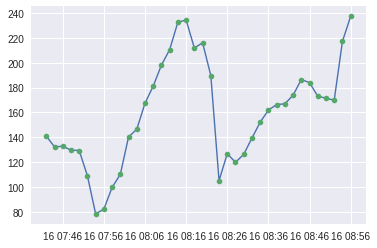

In [4]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values )
ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values, 'o' )
fig1.savefig("../plots/vels-ts.pdf",bbox_inches='tight')

In [5]:
# Read AMPERE data
ampFName = "../data/" + eventDate.strftime("%Y%m%d") + ".0000.86400.120.north.grd.ncdf"
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-05-16,2011-05-16 00:10:00,89.0,0.0,82.529999,60.080002,76.720001,67.349998,-2.50,-0.21
1,2011-05-16,2011-05-16 00:10:00,88.0,0.0,80.660004,31.370001,76.199997,41.020000,-2.55,-0.27
2,2011-05-16,2011-05-16 00:10:00,87.0,0.0,61.980000,1.050000,61.169998,10.080000,4.62,-0.28
3,2011-05-16,2011-05-16 00:10:00,86.0,0.0,32.880001,-19.570000,35.610001,-13.990000,13.99,-0.25
4,2011-05-16,2011-05-16 00:10:00,85.0,0.0,9.180000,-25.520000,13.440000,-23.559999,22.02,-0.18


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


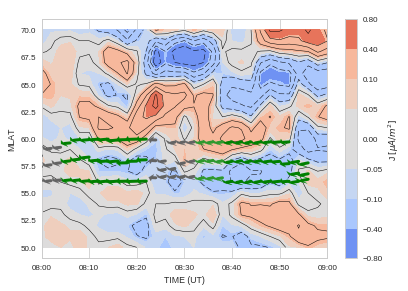

In [9]:
# Some temp constants
plotMltChsn = 23
plotJrCutoff = 0.
plotJrMin = -0.4
plotJrMax = 0.4
ticks = [ -0.8, -0.4, -0.1, -0.05, 0, 0.05, 0.1, 0.4, 0.8 ]
colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=10)
# Plotting
seaMap = ListedColormap(sns.color_palette("coolwarm",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= timeStart) & (ampDF["start_date"] <= timeEnd) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]
plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
jrVals = numpy.ma.masked_where(numpy.isnan(plotAmpDF["Jr"].values),plotAmpDF["Jr"].values)
ampPlot = ax.contourf(timeCntr, mlatCntr,jrVals.T, ticks,cmap=seaMap)
ax.contour(timeCntr, mlatCntr,jrVals.T, numpy.linspace(-0.5, 0.5, 9),
                 origin='lower',
                 linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label(r"J $ [\mu A/m^{2}]$")

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data
velColors = [ "#feebe2", "#fbb4b9", "#f768a1", "#c51b8a", "#7a0177" ]
# ax.scatter( fitsDF["date"].values, fitsDF["medLat"].values,\
#            c=fitsDF["velSAPS"].values, s=fitsDF["velSAPS"].values/3.,\
#           cmap=ListedColormap(sns.light_palette("Purple")), alpha=0.75)

ax.set_xlim( [timeStart, timeEnd] )
ax.set_ylim( plotMlatRange )

ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
seaMap = ListedColormap( sns.light_palette("green") )
ax2 = ax.twiny()
for index, row in fitsDF.iterrows():
    currCol = seaMap( colNorm(row['velSAPS']) )
    if row['velSAPS'] < saisVelCutoff:
        currCol = "#636363"
    # Min Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["minLat"],\
                row['endPtMinMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["minLat"], row["endPtTime"]-row["time"], row['endPtMinMLAT']-row["minLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Median Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["medLat"],\
                row['endPtMedMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["medLat"], row["endPtTime"]-row["time"], row['endPtMedMLAT']-row["medLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Max Lat loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["maxLat"],\
                row['endPtMaxMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["maxLat"], row["endPtTime"]-row["time"], row['endPtMaxMLAT']-row["maxLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
# Need to carefully set the x-axis
ax2.set_xlim([(timeStart.hour + timeStart.minute/60.)*arrowLenFactor,\
              (timeEnd.hour + timeEnd.minute/60.)*arrowLenFactor])
ax2.axis('off')

fig.savefig( "../plots/sapsSCW.pdf",bbox_inches='tight' )

In [7]:
print fitsDF[ ["date", "azimSAPS", "velSAPS"] ]

                  date   azimSAPS     velSAPS
0  2011-05-16 07:42:00  23.435134  140.982621
1  2011-05-16 07:44:00  20.697743  132.268742
2  2011-05-16 07:46:00  19.864341  132.805562
3  2011-05-16 07:48:00  19.768236  129.714436
4  2011-05-16 07:50:00  21.456099  129.335432
5  2011-05-16 07:52:00  23.594545  109.000643
6  2011-05-16 07:54:00  19.276911   78.293131
7  2011-05-16 07:56:00  10.056623   82.176861
8  2011-05-16 07:58:00  19.890412   99.621391
9  2011-05-16 08:00:00  20.410233  110.202033
10 2011-05-16 08:02:00  20.427979  140.303240
11 2011-05-16 08:04:00  20.029809  146.497726
12 2011-05-16 08:06:00  19.922040  167.429700
13 2011-05-16 08:08:00  19.473456  181.309917
14 2011-05-16 08:10:00  18.779410  198.198167
15 2011-05-16 08:12:00  15.183871  210.667368
16 2011-05-16 08:14:00  15.947264  232.794217
17 2011-05-16 08:16:00  18.604747  234.418744
18 2011-05-16 08:18:00   4.560890  211.914953
19 2011-05-16 08:20:00   5.418667  216.182130
20 2011-05-16 08:22:00   7.496504 